In [17]:
import os

import numpy as np
import osmnx as ox
import pandas as pd

ox.__version__

'2.0.0'

In [18]:
LOCATION = "41 Westover Drive, Asheville, NC"
RADIUS_METERS = 20_000

G = ox.graph_from_address(
    address=LOCATION,
    dist=RADIUS_METERS,
    dist_type="network",
    network_type="bike",
    simplify=True
)

In [19]:
print(f"Nodes: {len(G.nodes)}, Edges: {len(G.edges)}")

Nodes: 38629, Edges: 89992


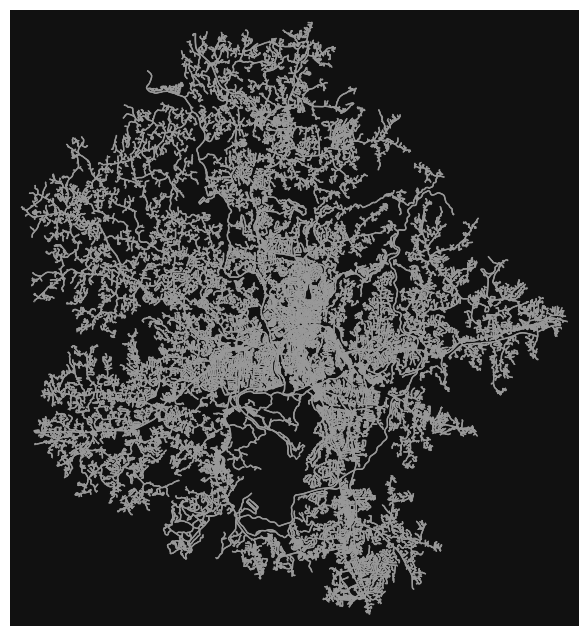

In [20]:
fig, ax = ox.plot_graph(G, node_size=0)

In [21]:
# add elevation data to the nodes (and calculate edge grades)
API_KEY = os.environ.get('GOOGLE_ELEVATION_API_KEY')
G = ox.elevation.add_node_elevations_google(G, api_key=API_KEY)
G = ox.elevation.add_edge_grades(G)

In [22]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,street_count,elevation,highway,railway,junction,geometry
osmid,,,,,,,,
169451021,35.582910,-82.607449,3,671.855469,NaN,NaN,NaN,POINT (-82.60745 35.58291)
169451028,35.583061,-82.609634,3,666.195435,NaN,NaN,NaN,POINT (-82.60963 35.58306)
169451041,35.613753,-82.541664,3,683.340149,NaN,NaN,NaN,POINT (-82.54166 35.61375)
169451046,35.614209,-82.542318,3,683.806152,NaN,NaN,NaN,POINT (-82.54232 35.61421)
169451060,35.593649,-82.632085,3,696.682251,NaN,NaN,NaN,POINT (-82.63209 35.59365)


In [23]:
gdf_edges.iloc[0]

osmid                                                 16416552
highway                                            residential
name                                               Eola Avenue
oneway                                                   False
reversed                                                 False
length                                              198.305131
grade                                                -0.028542
grade_abs                                             0.028542
geometry     LINESTRING (-82.607449 35.58291, -82.609634 35...
lanes                                                      NaN
service                                                    NaN
maxspeed                                                   NaN
ref                                                        NaN
bridge                                                     NaN
access                                                     NaN
width                                                  

In [24]:
# summary stats re: edge grades (drops any infinite/null values)
grades = pd.Series([d["grade_abs"] for _, _, d in ox.convert.to_undirected(G).edges(data=True)])
grades = grades.replace([np.inf, -np.inf], np.nan).dropna()

avg_grade = np.mean(grades)
print(f"Average street grade: {avg_grade * 100:.1f}%")

med_grade = np.median(grades)
print(f"Median street grade: {med_grade * 100:.1f}%")

Average street grade: 5.0%
Median street grade: 3.8%


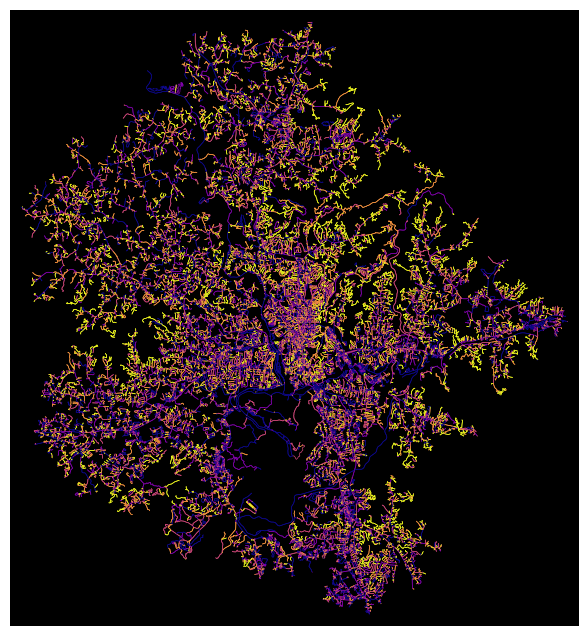

In [25]:
# edges binned and colored by grade
ec = ox.plot.get_edge_colors_by_attr(G, "grade_abs", cmap="plasma", num_bins=5, equal_size=True)
fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=0.5, node_size=0, bgcolor="k")

In [26]:
# save graph (for future analyses)
FILE_PATH = "../data/places/asheville.graphml"
ox.save_graphml(G, FILE_PATH)

In [27]:
# check that it worked
G = ox.load_graphml(FILE_PATH)
print(ox.basic_stats(G))

{'n': 38629, 'm': 89992, 'k_avg': 4.659297419037511, 'edge_length_total': 9013930.462093154, 'edge_length_avg': 100.1636863509329, 'streets_per_node_avg': 2.402883843744337, 'streets_per_node_counts': {0: 0, 1: 12248, 2: 269, 3: 24475, 4: 1580, 5: 53, 6: 3, 7: 1}, 'streets_per_node_proportions': {0: 0.0, 1: 0.3170674881565663, 2: 0.006963680136684874, 3: 0.6335913432913096, 4: 0.04090191307049108, 5: 0.0013720261979341946, 6: 7.76618602604261e-05, 7: 2.5887286753475367e-05}, 'intersection_count': 26381, 'street_length_total': 4608574.341575308, 'street_segment_count': 46263, 'street_length_avg': 99.6168502167025, 'circuity_avg': 1.1620897599645272, 'self_loop_proportion': 0.013466485096081102}
